In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
#Importation des datasets sur plusieurs années
df2012 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projet - Voiture et emissions de CO2/BASE CL MAJ JUIN 2012.csv', encoding='latin1', sep=';')
df2013 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projet - Voiture et emissions de CO2/gov2013.csv', encoding='latin1', sep=';')
df2014 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projet - Voiture et emissions de CO2/mars-2014-complete.csv', encoding='latin1', sep=';')

# EDA et PRE-PROCESSING

In [ ]:
#Harmonisation des noms de colonnes (nom de colonne dataset 2013 /=/ nom de colonne dataset 2012 et 2014)
#Nom de colonne = base 2013 (plus claire pour la compréhension)
dico={"lib_mrq": "Marque", "lib_mod_doss": "Modèle dossier", "lib_mod":"Modèle UTAC", "dscom": "Désignation commerciale", "cnit":"CNIT", "tvv":"Type Variante Version (TVV)", "typ_cbr":"Carburant",
      "hybride":"Hybride", "puiss_admin_98":"Puissance administrative","puiss_max":"Puissance maximale (kW)", "typ_boite_nb_rapp":"Boîte de vitesse",
      "conso_urb":"Consommation urbaine (l/100km)", "conso_exurb":"Consommation extra-urbaine (l/100km)", "conso_mixte":"Consommation mixte (l/100km)", "co2":"CO2 (g/km)",
      "co_typ_1":"CO type I (g/km)", "hc":"HC (g/km)", "nox":"NOX (g/km)", "hcnox":"HC+NOX (g/km)", "ptcl":"Particules (g/km)",
      "masse_ordma_min":"masse vide euro min (kg)", "masse_ordma_max":"masse vide euro max (kg)","champ_v9":"Champ V9", "date_maj":"Date de mise à jour"}

dico2={"cod_cbr":"Carburant",}

df2012 = df2012.rename(dico, axis=1)
df2014 = df2014.rename(dico, axis=1)
df2014 = df2014.rename(dico2, axis=1)

In [ ]:
#Conversion de la puissance max sur data 2012 en float (au lieu de int)
df2012['Puissance maximale (kW)'] = df2012['Puissance maximale (kW)'].astype('float')

#Conversion de la puissance max sur data 2014 en float (au lieu de object)
df2014['Puissance maximale (kW)'] = df2014['Puissance maximale (kW)'].str.replace(',', '.')
df2014['Puissance maximale (kW)'] = df2014['Puissance maximale (kW)'].astype('float')

#Conversion des Series object en float
var_columns = ['Consommation urbaine (l/100km)', 'Consommation extra-urbaine (l/100km)',
               'Consommation mixte (l/100km)', 'CO type I (g/km)', 'HC (g/km)', 'NOX (g/km)', 'HC+NOX (g/km)', 'Particules (g/km)']

#pour l'année 2012
for i in var_columns:
  df2012[i] = df2012[i].str.replace(',', '.') #Remplacement des virgules par des points
  df2012[i] = df2012[i].astype('float')       #Conversion de la colonne en décimales

#pour l'année 2014
for i in var_columns:
  df2014[i] = df2014[i].str.replace(',', '.') #Remplacement des virgules par des points
  df2014[i] = df2014[i].astype('float')       #Conversion de la colonne en décimales

#Les données des 3 dataset sont harmonisées :
#Même nom de colonne
#Même type de colonne

In [ ]:
#concaténation des datasets pour n'en former qu'un
df = pd.concat([df2012, df2013, df2014])
df.info()

#on réinitialise l'index pour faire corresepondre l'index à 1 seule ligne (et pas à 3 lignes)
df = df.reset_index(drop=True)
database = df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139946 entries, 0 to 55043
Data columns (total 30 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Marque                                139946 non-null  object 
 1   Modèle dossier                        139946 non-null  object 
 2   Modèle UTAC                           139946 non-null  object 
 3   Désignation commerciale               139946 non-null  object 
 4   CNIT                                  139946 non-null  object 
 5   Type Variante Version (TVV)           139946 non-null  object 
 6   Carburant                             139946 non-null  object 
 7   Hybride                               139946 non-null  object 
 8   Puissance administrative              139946 non-null  int64  
 9   Puissance maximale (kW)               139946 non-null  float64
 10  Boîte de vitesse                      139946 non-null  object 
 11  C

In [ ]:
#Suppression des colonnes non pertinentes
useless_col = ['Marque', 'Modèle dossier', 'Modèle UTAC', 'Désignation commerciale', 'CNIT', 'Type Variante Version (TVV)', 'Boîte de vitesse', 'HC (g/km)',
               'HC+NOX (g/km)', 'Champ V9', 'Date de mise à jour', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29']
df = df.drop(useless_col, axis=1)

In [ ]:
#Nombre d'entrées environ égal à 140k
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139946 entries, 0 to 139945
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Carburant                             139946 non-null  object 
 1   Hybride                               139946 non-null  object 
 2   Puissance administrative              139946 non-null  int64  
 3   Puissance maximale (kW)               139946 non-null  float64
 4   Consommation urbaine (l/100km)        139829 non-null  float64
 5   Consommation extra-urbaine (l/100km)  139829 non-null  float64
 6   Consommation mixte (l/100km)          139843 non-null  float64
 7   CO2 (g/km)                            139843 non-null  float64
 8   CO type I (g/km)                      139338 non-null  float64
 9   NOX (g/km)                            139338 non-null  float64
 10  Particules (g/km)                     131429 non-null  float64
 11  

In [ ]:
#Nombre d'entrée UNIQUES (après suppression des doublons)
#Nombre de véhicule uniques égal à 15k
#Les déséquilibres entre catégories s'ajustent.
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14958 entries, 0 to 139945
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Carburant                             14958 non-null  object 
 1   Hybride                               14958 non-null  object 
 2   Puissance administrative              14958 non-null  int64  
 3   Puissance maximale (kW)               14958 non-null  float64
 4   Consommation urbaine (l/100km)        14916 non-null  float64
 5   Consommation extra-urbaine (l/100km)  14916 non-null  float64
 6   Consommation mixte (l/100km)          14928 non-null  float64
 7   CO2 (g/km)                            14928 non-null  float64
 8   CO type I (g/km)                      14813 non-null  float64
 9   NOX (g/km)                            14813 non-null  float64
 10  Particules (g/km)                     12666 non-null  float64
 11  masse vide eur

In [ ]:
#Nombre de valeurs manquantes par variable
df.isnull().sum()

Carburant                                  0
Hybride                                    0
Puissance administrative                   0
Puissance maximale (kW)                    0
Consommation urbaine (l/100km)            42
Consommation extra-urbaine (l/100km)      42
Consommation mixte (l/100km)              30
CO2 (g/km)                                30
CO type I (g/km)                         145
NOX (g/km)                               145
Particules (g/km)                       2292
masse vide euro min (kg)                   0
masse vide euro max (kg)                   0
Carrosserie                                0
gamme                                      0
dtype: int64

In [ ]:
#Calcul du taux de valeurs manquantes par colonnes
tauxNA = {}

for i in df.columns:
  missingrate = (df[i].isnull().sum()/len(df[i]))*100
  tauxNA[i] = missingrate
print(tauxNA)

{'Carburant': 0.0, 'Hybride': 0.0, 'Puissance administrative': 0.0, 'Puissance maximale (kW)': 0.0, 'Consommation urbaine (l/100km)': 0.2807862013638187, 'Consommation extra-urbaine (l/100km)': 0.2807862013638187, 'Consommation mixte (l/100km)': 0.20056157240272765, 'CO2 (g/km)': 0.20056157240272765, 'CO type I (g/km)': 0.9693809332798502, 'NOX (g/km)': 0.9693809332798502, 'Particules (g/km)': 15.322904131568391, 'masse vide euro min (kg)': 0.0, 'masse vide euro max (kg)': 0.0, 'Carrosserie': 0.0, 'gamme': 0.0}


La corrélation entre ces variables n'est pas vérifiée. le coefficient de corrélation n'est que de : 0.06
On peut observer la relation non linéaire entre ces 2 variables au travers d'un graphique : 


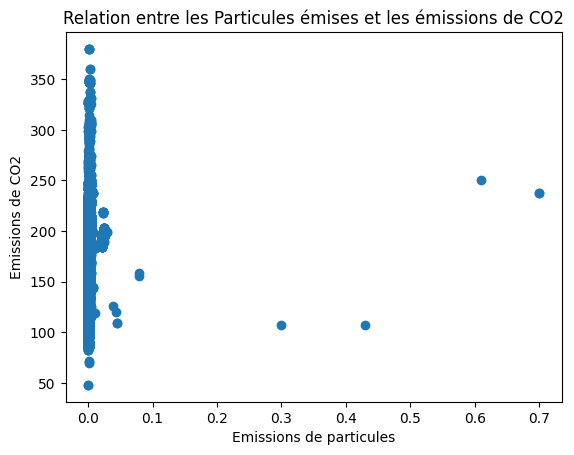

In [ ]:
#Les particules possèdent un % élevé de valeurs manquantes.
#Observons la corrélation entre les particules et la variable cible CO2

print("La corrélation entre ces variables n'est pas vérifiée. le coefficient de corrélation n'est que de :", np.round(df['Particules (g/km)'].corr(df['CO2 (g/km)']), 2))
print("On peut observer la relation non linéaire entre ces 2 variables au travers d'un graphique : ")
plt.scatter(df['Particules (g/km)'], df['CO2 (g/km)'])
plt.title('Relation entre les Particules émises et les émissions de CO2')
plt.xlabel('Emissions de particules')
plt.ylabel('Emissions de CO2');

In [ ]:
#On supprime donc cette variable de notre jeu de données
df = df.drop('Particules (g/km)', axis=1)

In [ ]:
#Gestion des NaN
#Suppression des lignes dont les données sont manquantes
df = df.dropna(axis=0, how='any', subset=['Consommation urbaine (l/100km)', 'Consommation extra-urbaine (l/100km)', 'Consommation mixte (l/100km)', 'CO2 (g/km)'])

#Complétion des valeurs manquantes avec leur médiane
df['CO type I (g/km)'] = df['CO type I (g/km)'].fillna(df['CO type I (g/km)'].median())
df['NOX (g/km)'] = df['NOX (g/km)'].fillna(df['NOX (g/km)'].median())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14916 entries, 0 to 139945
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Carburant                             14916 non-null  object 
 1   Hybride                               14916 non-null  object 
 2   Puissance administrative              14916 non-null  int64  
 3   Puissance maximale (kW)               14916 non-null  float64
 4   Consommation urbaine (l/100km)        14916 non-null  float64
 5   Consommation extra-urbaine (l/100km)  14916 non-null  float64
 6   Consommation mixte (l/100km)          14916 non-null  float64
 7   CO2 (g/km)                            14916 non-null  float64
 8   CO type I (g/km)                      14916 non-null  float64
 9   NOX (g/km)                            14916 non-null  float64
 10  masse vide euro min (kg)              14916 non-null  int64  
 11  masse vide eur

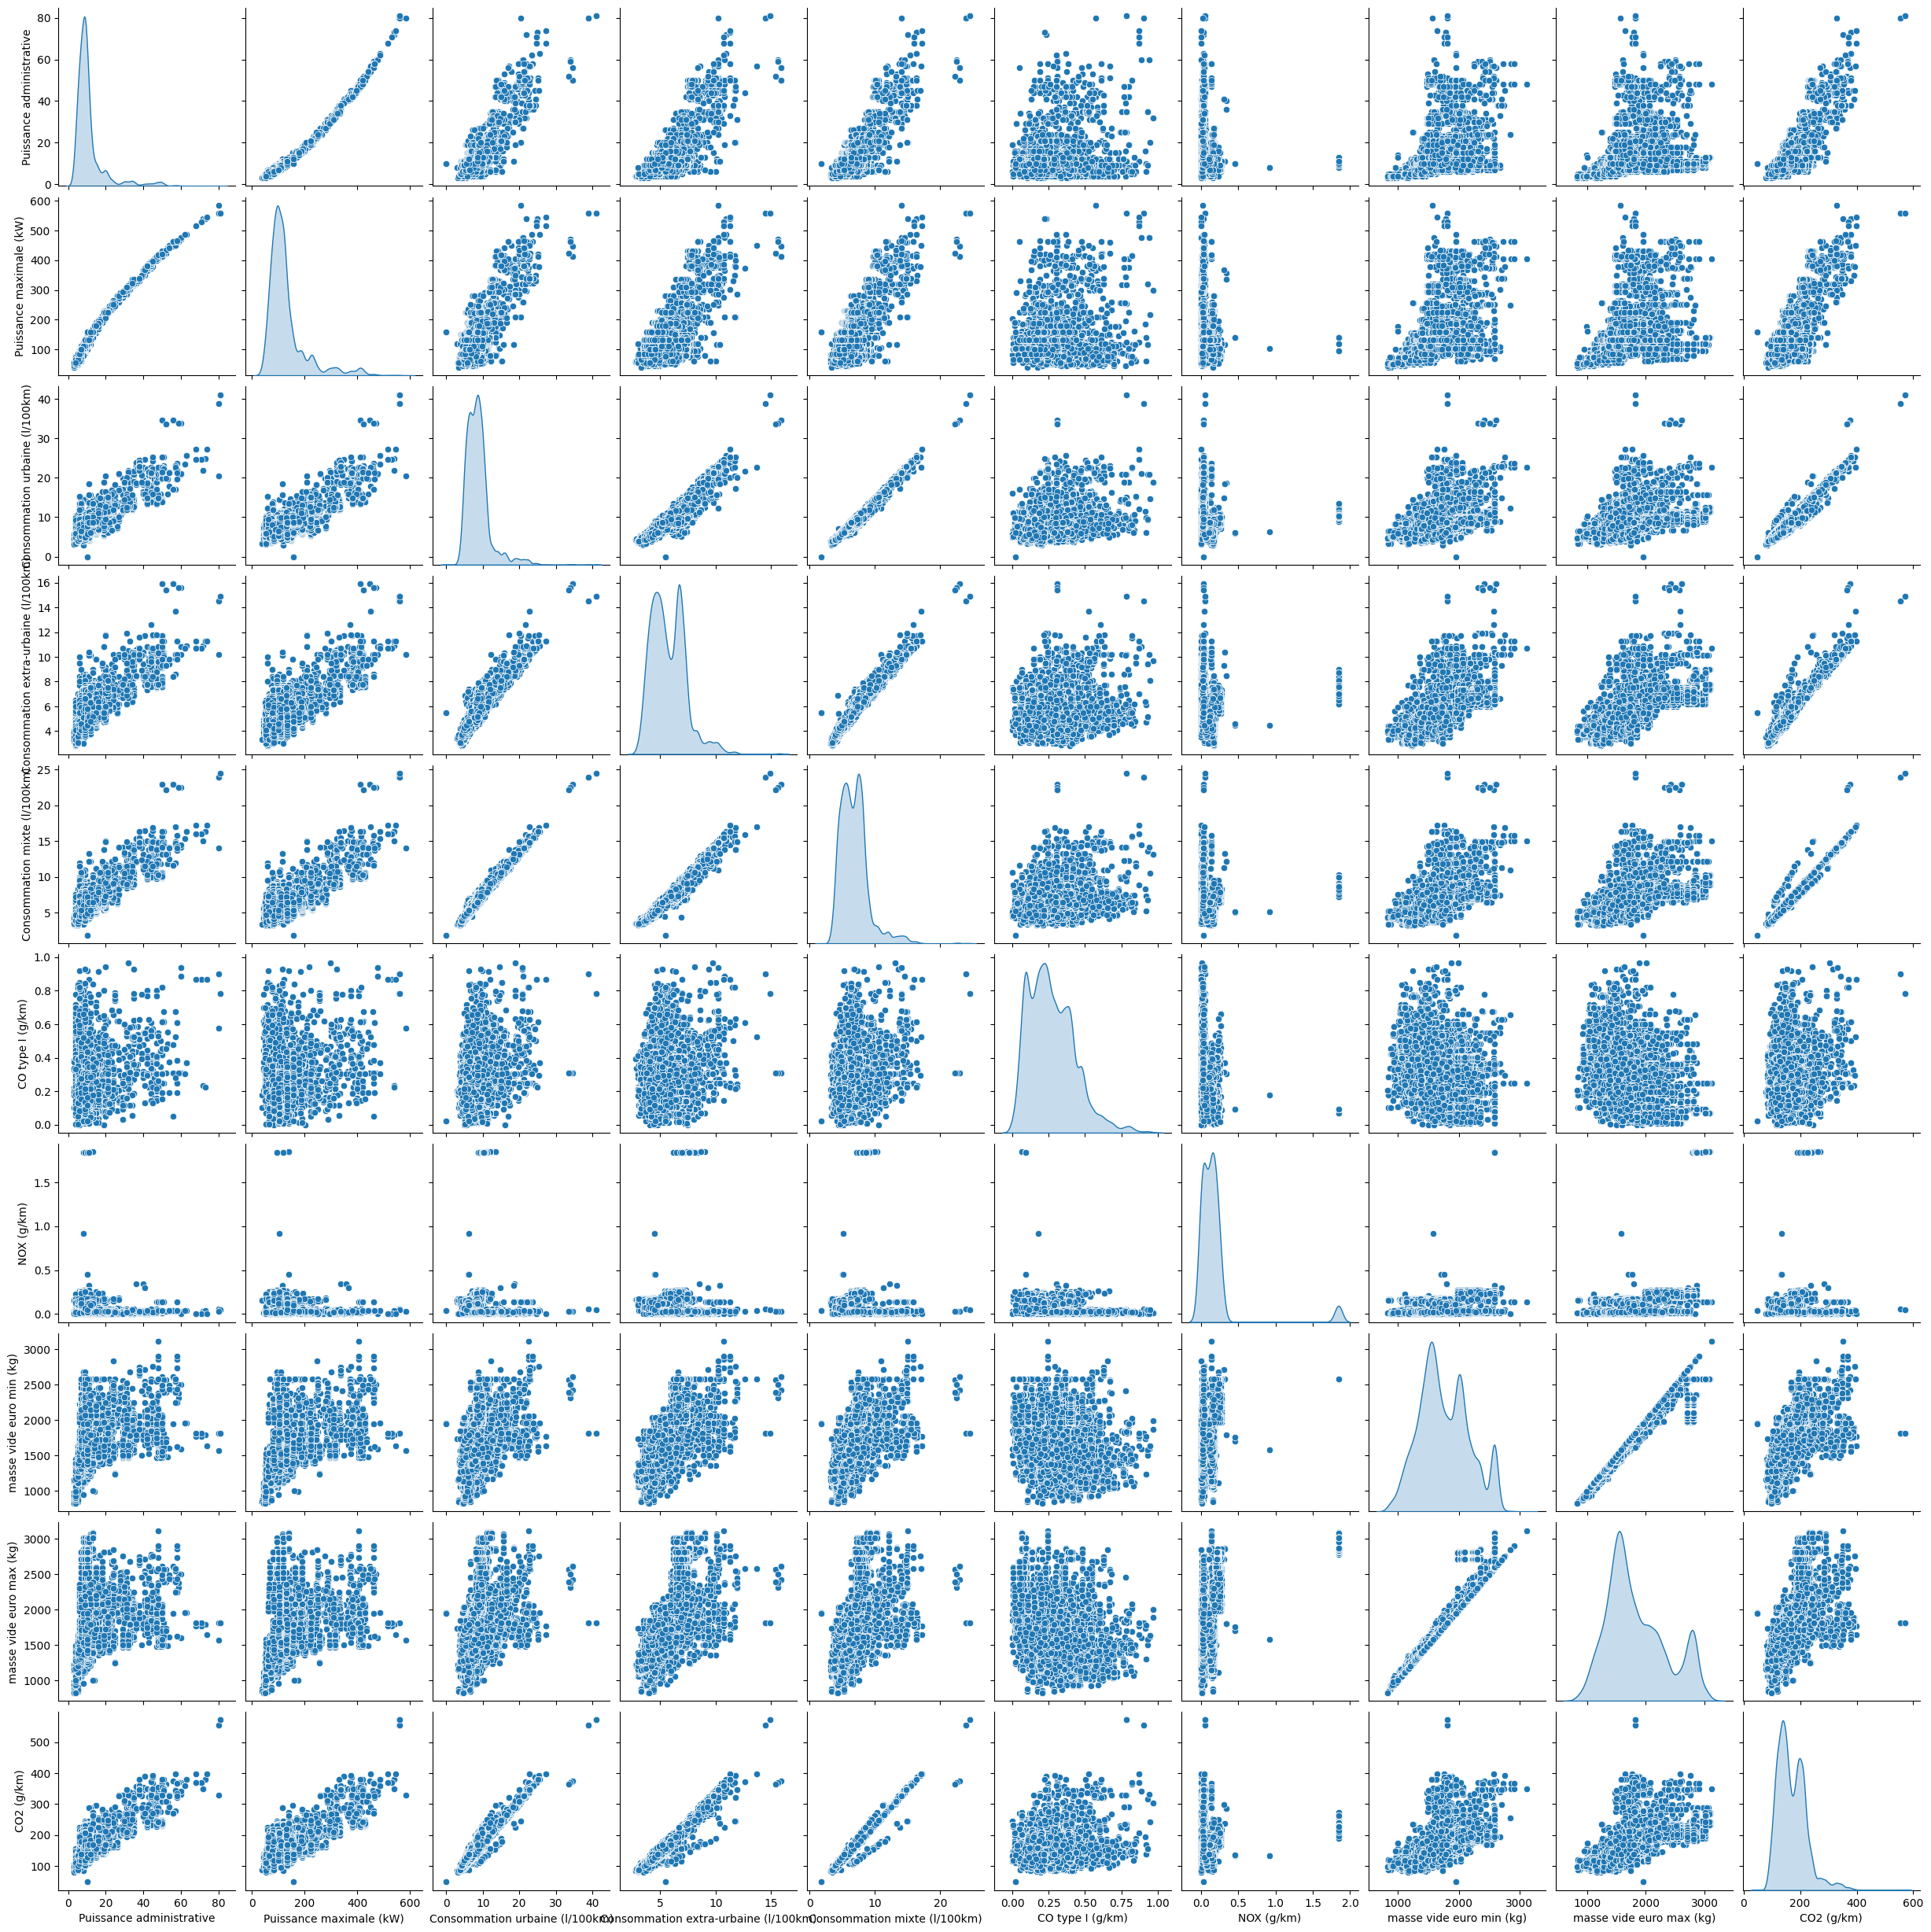

In [ ]:
#On peut observer les relations linéaires (ou pas) des variables numériques avec la variable cible au travers d'un pairplot :
sns.pairplot(df[['Puissance administrative','Puissance maximale (kW)', 'Consommation urbaine (l/100km)',
       'Consommation extra-urbaine (l/100km)', 'Consommation mixte (l/100km)', 'CO type I (g/km)', 'NOX (g/km)',
       'masse vide euro min (kg)', 'masse vide euro max (kg)', 'CO2 (g/km)']], diag_kind='kde')


In [ ]:
print("On observe que les Co de type I ne sont pas corrélés avec la variable cible CO2. Idem pour le NOX. La masse à vide semble moins corrélée avec la variable cible que les autres variables.")
df = df.drop(['CO type I (g/km)', 'NOX (g/km)'], axis=1)

On observe que les Co de type I ne sont pas corrélés avec la variable cible CO2. Idem pour le NOX. La masse à vide semble moins corrélée avec la variable cible que les autres variables.


<ipython-input-20-f6bee7a829cd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr()


[Text(0.5, 1.0, 'Heatmap des variables numériques')]

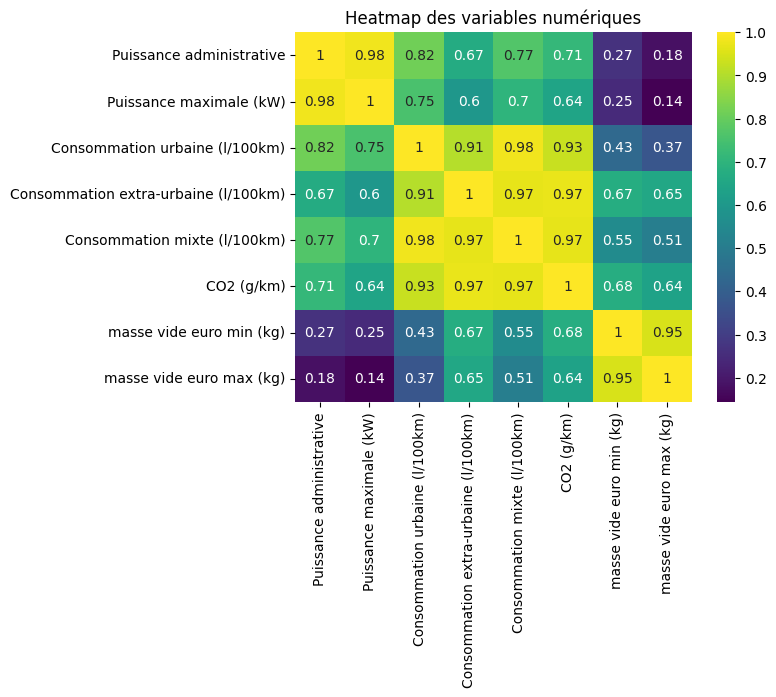

In [ ]:
#Les variables explicatives trop corrélées entre elles peuvent parfois entraîner une baisse des résultats du modèle
cor = df.corr()
sns.heatmap(cor, annot=True, cmap='viridis').set(title='Heatmap des variables numériques')

#Les variables numériques suivantes sont très corrélées entre elles :
# - puissances
# - Consommations
# - Masse à vide

In [ ]:
#Il faut traiter les valeurs extrêmes de chaque variable numérique qui sera utilisée dans notre modèle
var_num = df.select_dtypes(include=['float', 'int'])
var_num.columns

Index(['Puissance administrative', 'Puissance maximale (kW)',
       'Consommation urbaine (l/100km)',
       'Consommation extra-urbaine (l/100km)', 'Consommation mixte (l/100km)',
       'CO2 (g/km)', 'masse vide euro min (kg)', 'masse vide euro max (kg)'],
      dtype='object')

Seuil de valeur extrême (Q3 * 1.5(Q3-Q1)) >: 305.5 g de CO2 émis par km
% de valeur extrêmes : 2.0 %

Les valeurs extrêmes ne semblent pas être aberrantes, sauf pour les valeurs >500g/km 
Nombre de valeurs aberrantes : 6
Modèle(s) concerné(s) : ['ONE-77']

Ces valeurs ne concernent qu'un modèle de voiture : l'Aston Martin one-77. Ces émissions de CO2 sont bien estimées à + de 500g/km.
Nous ne sommes pas en présence d'une valeur aberrante mais bien d'une valeur extrême


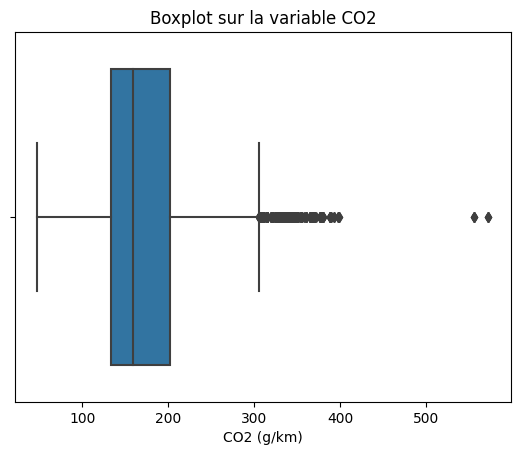

In [ ]:
#Gestion outliers CO2 (g/km)
sns.boxplot(x = df['CO2 (g/km)']).set(title='Boxplot sur la variable CO2');
Q3 = df['CO2 (g/km)'].quantile(q=0.75)
Q1 = df['CO2 (g/km)'].quantile(q=0.25)
val_extr = Q3 + 1.5*(Q3-Q1)
print("Seuil de valeur extrême (Q3 * 1.5(Q3-Q1)) >:", val_extr,"g de CO2 émis par km")

CO2_valextr = df.loc[df['CO2 (g/km)'] > val_extr]
print("% de valeur extrêmes :", np.round(len(CO2_valextr)/len(df['CO2 (g/km)'])*100, 0), "%")

print("\nLes valeurs extrêmes ne semblent pas être aberrantes, sauf pour les valeurs >500g/km ")
CO2_abb = df.loc[df['CO2 (g/km)'] > 500] #df sur les valeurs >500
print("Nombre de valeurs aberrantes :", len(CO2_abb)) #Calcul du nombre de valeur qui semblent aberrantes

print("Modèle(s) concerné(s) :", database.loc[CO2_abb.index]['Modèle dossier'].unique())
print("\nCes valeurs ne concernent qu'un modèle de voiture : l'Aston Martin one-77. Ces émissions de CO2 sont bien estimées à + de 500g/km.\nNous ne sommes pas en présence d'une valeur aberrante mais bien d'une valeur extrême")

<Axes: xlabel='masse vide euro max (kg)'>

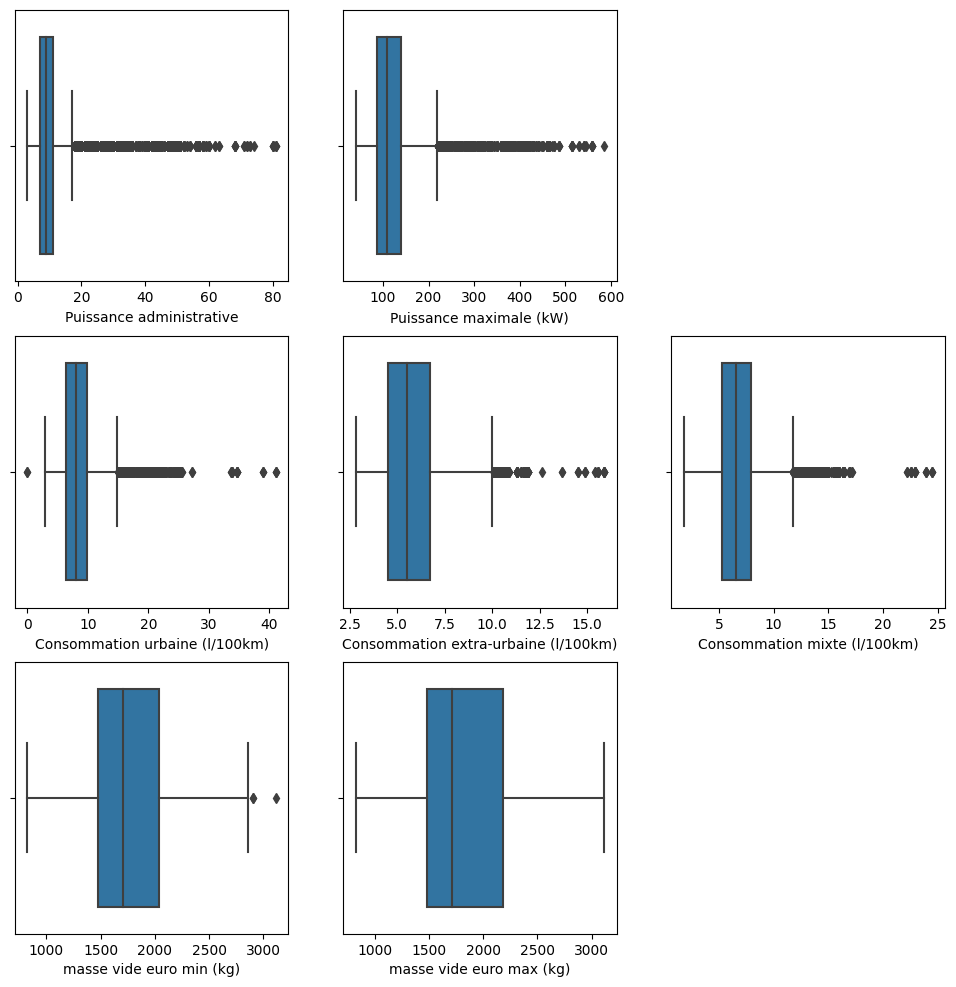

In [ ]:
#Gestion outliers

figure = plt.figure(figsize=(12,12))
plt.subplot(331)
sns.boxplot(x=df['Puissance administrative'])

plt.subplot(332)
sns.boxplot(x=df['Puissance maximale (kW)'])

plt.subplot(334)
sns.boxplot(x=df['Consommation urbaine (l/100km)'])

plt.subplot(335)
sns.boxplot(x=df['Consommation extra-urbaine (l/100km)'])

plt.subplot(336)
sns.boxplot(x=df['Consommation mixte (l/100km)'])

plt.subplot(337)
sns.boxplot(x=df['masse vide euro min (kg)'])

plt.subplot(338)
sns.boxplot(x=df['masse vide euro max (kg)'])


In [ ]:
#Puissance administrative
Q3 = df['Puissance administrative'].quantile(q=0.75)
Q1 = df['Puissance administrative'].quantile(q=0.25)
val_extr = Q3 + 1.5*(Q3-Q1)
print("Seuil de valeur extrême (Q3 * 1.5(Q3-Q1)) >:", val_extr)

admin_valextr = df.loc[df['Puissance administrative'] > val_extr]
print("% de valeur extrêmes :", np.round(len(admin_valextr)/len(df['Puissance administrative'])*100, 0), "%")

print("\nLes valeurs extrêmes ne semblent pas être aberrantes, sauf pour les valeurs >65")
admin_abb = df.loc[df['Puissance administrative'] > 65] #df sur les valeurs >65
print("Nombre de valeurs aberrantes :", len(admin_abb)) #Calcul du nombre de valeur qui semblent aberrantes

print("Modèle(s) concerné(s) :", database.loc[admin_abb.index]['Modèle dossier'].unique(), '\nGamme(s) de voiture concernée(s) :', database.loc[admin_abb.index]['gamme'].unique())
print("\nCes valeurs ne concernent que des modèles de voiture de Luxe. Il ne s'agit donc pas de valeurs aberrantes.")

Seuil de valeur extrême (Q3 * 1.5(Q3-Q1)) >: 17.0
% de valeur extrêmes : 12.0 %

Les valeurs extrêmes ne semblent pas être aberrantes, sauf pour les valeurs >65
Nombre de valeurs aberrantes : 20
Modèle(s) concerné(s) : ['AVENTADOR' 'ONE-77' 'F12' 'LAFERRARI'] 
Gamme(s) de voiture concernée(s) : ['LUXE']

Ces valeurs ne concernent que des modèles de voiture de Luxe. Il ne s'agit donc pas de valeurs aberrantes.


In [ ]:
#Puissance maximale

print("\nLes valeurs extrêmes ne semblent pas être aberrantes, sauf pour les valeurs > 520")
maxi_abb = df.loc[df['Puissance maximale (kW)'] > 520] #df sur les valeurs >520
print("Nombre de valeurs aberrantes :", len(maxi_abb)) #Calcul du nombre de valeur qui semblent aberrantes

print("Modèle(s) concerné(s) :", database.loc[maxi_abb.index]['Modèle dossier'].unique(), '\nGamme(s) de voiture concernée(s) :', database.loc[maxi_abb.index]['gamme'].unique())
print("\nCes valeurs ne concernent que des modèles de voiture de Luxe. Il ne s'agit donc pas de valeurs aberrantes.")


Les valeurs extrêmes ne semblent pas être aberrantes, sauf pour les valeurs > 520
Nombre de valeurs aberrantes : 14
Modèle(s) concerné(s) : ['ONE-77' 'F12' 'LAFERRARI' 'AVENTADOR'] 
Gamme(s) de voiture concernée(s) : ['LUXE']

Ces valeurs ne concernent que des modèles de voiture de Luxe. Il ne s'agit donc pas de valeurs aberrantes.


In [ ]:
#Consommation urbaine

print("\nLes valeurs extrêmes ne semblent pas être aberrantes, sauf pour les valeurs > 30")
urb_abb = df.loc[df['Consommation urbaine (l/100km)'] > 30] #df sur les valeurs >30
print("Nombre de valeurs aberrantes :", len(urb_abb)) #Calcul du nombre de valeur qui semblent aberrantes

print("Modèle(s) concerné(s) :", database.loc[urb_abb.index]['Modèle dossier'].unique(), '\nGamme(s) de voiture concernée(s) :', database.loc[urb_abb.index]['gamme'].unique())
print("\nCes valeurs ne concernent que des modèles de voiture de Luxe. Il ne s'agit donc certainement pas de valeurs aberrantes.")

#La même logique est applicable pour la consommation extra_urbaine et mixte. Il n'y a pas de valeur aberrante à retraiter du jeu de données.


Les valeurs extrêmes ne semblent pas être aberrantes, sauf pour les valeurs > 30
Nombre de valeurs aberrantes : 18
Modèle(s) concerné(s) : ["CS'SPORTS CONVERTIBL" 'CONTINENTAL GTC' 'CONTINENTAL FS'
 'CONTINENTAL FS SPEED' 'CONTINENTAL GT' 'CONTINENTAL GT SPEED'
 'CONTINENTAL SUPERSPO' 'CONTINENTAL GTCSPEED' 'ONE-77'] 
Gamme(s) de voiture concernée(s) : ['LUXE']

Ces valeurs ne concernent que des modèles de voiture de Luxe. Il ne s'agit donc certainement pas de valeurs aberrantes.


In [ ]:
#Enfin, pour la masse à vide, les valeurs extrêmes sont proches des quartiles. Il n'y a donc pas lieu de chercher à savoir si ces valeurs sont aberrantes

In [ ]:
#Regroupement de valeurs pour harmoniser les classes Carrosserie, Carburant et Gamme
df = df.replace(to_replace=['COMBISPCACE', 'GP/ES', 'GN/ES', 'MOY-INFERIEURE', 'MOY-INF'], value=['COMBISPACE', 'ES/GP', 'ES/GN', 'MOY-INFER', 'MOY-INFER'])

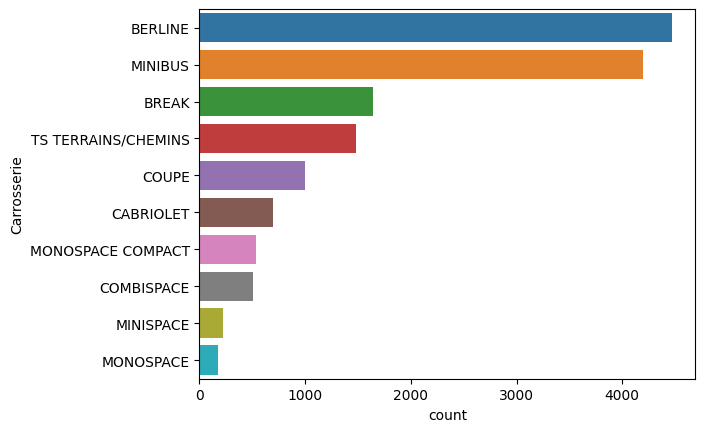

In [ ]:
#Répartition entre les différentes catégories de Carrosserie sur notre jeu de données
sns.countplot(y='Carrosserie', data=df, order = df['Carrosserie'].value_counts().index);

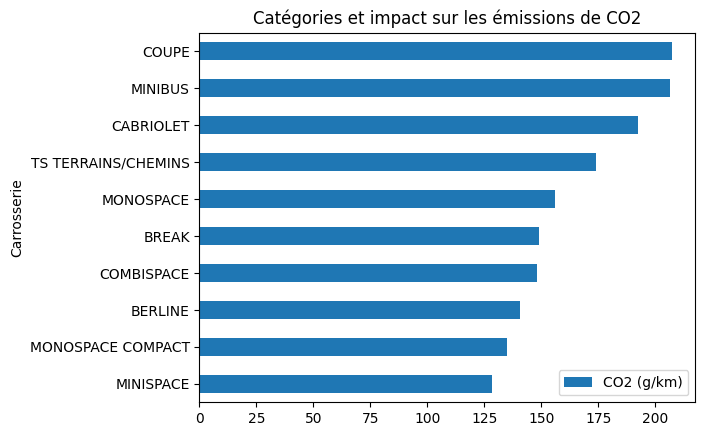

In [ ]:
#Moyenne des émissions de CO2 par catégorie de Carrosserie
categorie = df.groupby(['Carrosserie']).agg({'CO2 (g/km)': 'mean'})
categorie.sort_values(by='CO2 (g/km)').plot(kind='barh', title='Catégories et impact sur les émissions de CO2');

In [ ]:
#En étudiant le graphique, on peut réduire le nombre de classes en regroupant certaines d'entre elles :
#SPORT = COUPE + CABRIOLET
#VOLUMINEUSE = MONOSPACE + BREAK + COMBISPACE
#COMPACTE = BERLINE + MONOSPACE COMPACT + MINISPACE
df = df.replace(to_replace=['COUPE', 'CABRIOLET', 'MONOSPACE', 'BREAK', 'COMBISPACE', 'BERLINE', 'MONOSPACE COMPACT', 'MINISPACE'], value=['SPORT', 'SPORT', 'VOLUMINEUSE', 'VOLUMINEUSE', 'VOLUMINEUSE', 'COMPACTE', 'COMPACTE', 'COMPACTE'])

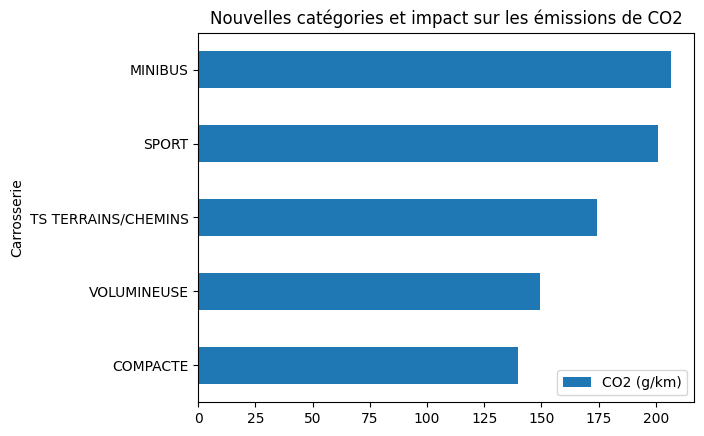

In [ ]:
#Moyenne des émissions de CO2 par nouvelle classes de Carrosserie
categorie = df.groupby(['Carrosserie']).agg({'CO2 (g/km)': 'mean'})
categorie.sort_values(by='CO2 (g/km)').plot(kind='barh', title='Nouvelles catégories et impact sur les émissions de CO2');

In [ ]:
#Vérifions qu'il y a un lien de corrélation entre la Carrosserie et les émissions de CO2 par un test ANOVA
## Les hypothèses :
print("H0 : Il n'y a pas d'influence significative de la Carrosserie sur l'émission de co2")
print("H1 : Il y a une influence significative de la Carrosserie sur l'émission de co2")

# On renomme la catégorie pour éviter une erreur liée aux espaces
df = df.rename({"CO2 (g/km)": "co2"}, axis=1)

result = statsmodels.formula.api.ols("co2 ~ Carrosserie", data=df).fit()
display(statsmodels.api.stats.anova_lm(result))

df = df.rename({"co2": "CO2 (g/km)"}, axis=1)


#S'il n'y a pas de dépendance, suppression de cette variable dans notre jeu de données
#Si il y a bien une dépendance, il faut discrétiser et dichotomiser (one hot encoding) la variable pour la rendre exploitable par le modèle

H0 : Il n'y a pas d'influence significative de la Carrosserie sur l'émission de co2
H1 : Il y a une influence significative de la Carrosserie sur l'émission de co2


,df,sum_sq,mean_sq,F,PR(>F)
Carrosserie,4.0,1.302824e+07,3.257060e+06,1892.279451,0.0
Residual,14911.0,2.566536e+07,1.721236e+03,NaN,NaN


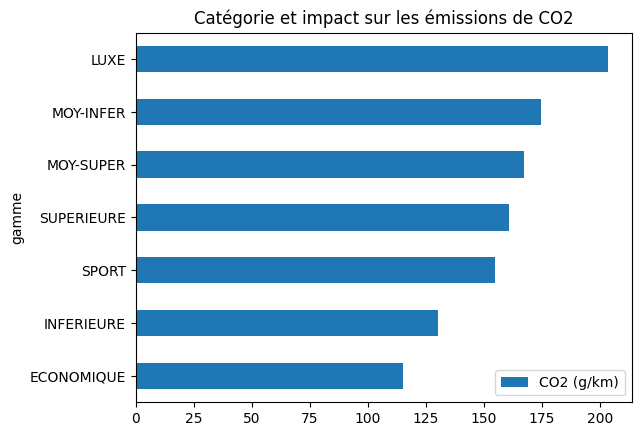

In [ ]:
#Impact par classe de gamme sur le CO2
categorie = df.groupby(['gamme']).agg({'CO2 (g/km)': 'mean'})
categorie.sort_values(by='CO2 (g/km)').plot(kind='barh', title='Catégorie et impact sur les émissions de CO2');

In [ ]:
#Répartition des classes de gamme
df['gamme'].value_counts()

MOY-INFER     6048
LUXE          2679
MOY-SUPER     2433
INFERIEURE    1870
SUPERIEURE    1581
ECONOMIQUE     296
SPORT            9
Name: gamme, dtype: int64

In [ ]:
#Au vue du graphique et du nombre d'entrée pour chacune des classes de Gamme, on peut regrouper les valeurs comme suit :
# - LUXE = LUXE
# - MOYENNE = MOY-INFER + MOY-SUPER + SUPERIEURE + SPORT
# - INFERIEURE = INFERIEURE + ECONOMIQUE
df = df.replace(['MOY-INFER', 'MOY-SUPER', 'SUPERIEURE', 'SPORT', 'ECONOMIQUE'], ['MOYENNE', 'MOYENNE', 'MOYENNE', 'MOYENNE', 'INFERIEURE'])

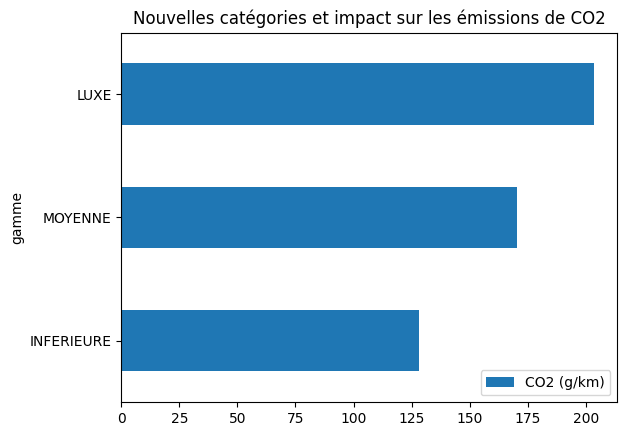

In [ ]:
#Impact par nouvelle classe de gamme sur le CO2
categorie = df.groupby(['gamme']).agg({'CO2 (g/km)': 'mean'})
categorie.sort_values(by='CO2 (g/km)').plot(kind='barh', title='Nouvelles catégories et impact sur les émissions de CO2');

In [ ]:
#La variance augmente lorsque l'on regroupe les données mais l'analyse est beaucoup plus accessible et compréhensible.

In [ ]:
#Vérifions qu'il y a un lien de corrélation entre la gamme et les émissions de CO2 par un test ANOVA
## Les hypothèses :
print("H0 : Il n'y a pas d'influence significative de la gamme sur l'émission de co2")
print("H1 : Il y a une influence significative de la gamme sur l'émission de co2")

# On renomme la catégorie pour éviter une erreur liée aux espaces
df = df.rename({"CO2 (g/km)": "co2"}, axis=1)

result = statsmodels.formula.api.ols("co2 ~ gamme", data=df).fit()
display(statsmodels.api.stats.anova_lm(result))

df = df.rename({"co2": "CO2 (g/km)"}, axis=1)

#S'il n'y a pas de dépendance, suppression de cette variable dans notre jeu de données
#Si il y a bien une dépendance, il faut discrétiser et dichotomiser (one hot encoding) la variable pour la rendre exploitable par le modèle

H0 : Il n'y a pas d'influence significative de la gamme sur l'émission de co2
H1 : Il y a une influence significative de la gamme sur l'émission de co2


,df,sum_sq,mean_sq,F,PR(>F)
gamme,2.0,6.764987e+06,3.382494e+06,1579.872456,0.0
Residual,14913.0,3.192861e+07,2.140992e+03,NaN,NaN


In [ ]:
#Regroupement des valeurs de la catégorie Carburant

df['Carburant'].value_counts()
#GO = DIESEL
#ES = ESSENCE
#EH = ESSENCE-ELECTRICITE (hybride non rechargeable)
#ES/GP = ESSENCE-GPL (Gaz pétrole liquéfié - butane ou propane)
#FE = SUPERETHANOL
#ES/GN = ESSENCE-GAZ NATUREL
#GH = DIESEL-ELECTRICITE (hybride non rechargeable)
#GN = GAZ NATUREL
#GL = DIESEL-ELECTRICITE (hybride rechargeable)

GO       9598
ES       4945
EH        156
ES/GP      68
FE         42
ES/GN      40
GH         38
GN         27
GL          2
Name: Carburant, dtype: int64

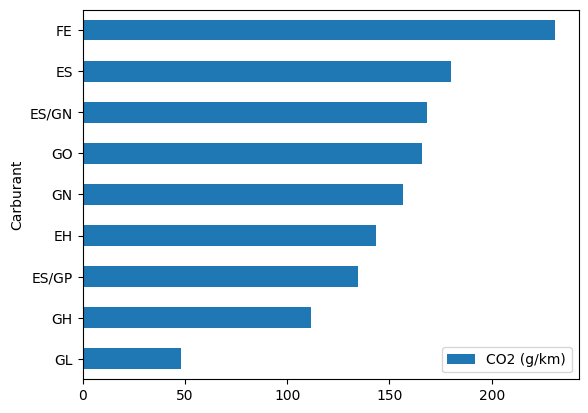

In [ ]:
#impact de chaque classe sur les émission de CO2 avant regroupement
categorie = df.groupby(['Carburant']).agg({'CO2 (g/km)': 'mean'})
categorie.sort_values(by='CO2 (g/km)').plot(kind='barh');

In [ ]:
#Vérifions qu'il y a un lien de corrélation entre le carburant et les émission de CO2 par un test ANOVA
## Les hypothèses :
print("H0 : Il n'y a pas d'influence significative ddu carburant sur l'émission de co2")
print("H1 : Il y a une influence significative ddu carburant sur l'émission de co2")

# On renomme la catégorie pour éviter une erreur liée aux espaces
df = df.rename({"CO2 (g/km)": "co2"}, axis=1)

result = statsmodels.formula.api.ols("co2 ~ Carburant", data=df).fit()
display(statsmodels.api.stats.anova_lm(result))

df = df.rename({"co2": "CO2 (g/km)"}, axis=1)

H0 : Il n'y a pas d'influence significative ddu carburant sur l'émission de co2
H1 : Il y a une influence significative ddu carburant sur l'émission de co2


,df,sum_sq,mean_sq,F,PR(>F)
Carburant,8.0,1.137123e+06,142140.342676,56.418665,4.951873e-91
Residual,14907.0,3.755647e+07,2519.385057,NaN,NaN


In [ ]:
#On remarque que l'influence des différents type de carburant sur les émissions varient.
#Même si le superéthanol contient un faible nombre d'entrées dans le jeu de données, il a son importance dans l'étude puisqu'il se distingue beaucoup des autres classes.
#Regroupement des valeurs comme suit :
# - GO = DIESEL
# - ES = ESSENCE
# - FE = SUPERETHANOL
# - GN = GAZ NATUREL
# - GO+ = GH, GL (DIESEL-ELECTRICITE)
# - ES+ = EH, ES/GP, ES/GN
df = df.replace(['GH', 'GL', 'EH', 'ES/GP', 'ES/GN'], ['GO+', 'GO+', 'ES+', 'ES+', 'ES+'])

#Le regroupement des véhicules dans une catégorie plus large n'est pas un problème car la variable Hybride permet de faire cette distinction

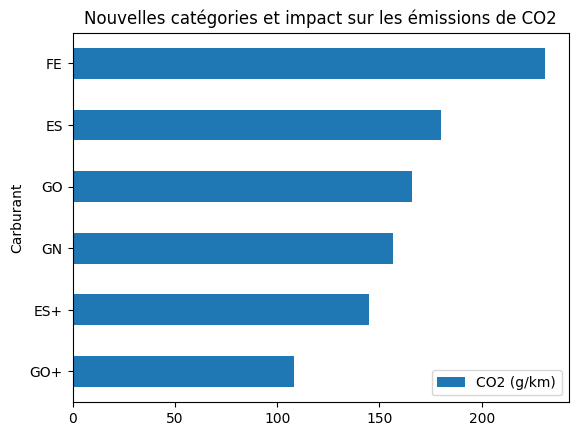

In [ ]:
#Impact des nouvelles classes créées sur les émissions de CO2
categorie = df.groupby(['Carburant']).agg({'CO2 (g/km)': 'mean'})
categorie.sort_values(by='CO2 (g/km)').plot(kind='barh', title='Nouvelles catégories et impact sur les émissions de CO2');

In [ ]:
#Il faut encoder les variables catégorielles de notre jeu de données pour les rendre exploitables par le modèle

In [ ]:
df.columns
#Encodage à réaliser sur Carburant, Hybride, Carroserie et gamme

Index(['Carburant', 'Hybride', 'Puissance administrative',
       'Puissance maximale (kW)', 'Consommation urbaine (l/100km)',
       'Consommation extra-urbaine (l/100km)', 'Consommation mixte (l/100km)',
       'CO2 (g/km)', 'masse vide euro min (kg)', 'masse vide euro max (kg)',
       'Carrosserie', 'gamme'],
      dtype='object')

In [ ]:
#Classes possibles pour la catégorie Hybride
df['Hybride'].unique()

array(['non', 'oui'], dtype=object)

In [ ]:
#Encodage ONE-HOT de la variable Carburant, Gamme, Carresserie et Hybride
df = df.join(pd.get_dummies(df[['Carburant', 'gamme', 'Carrosserie', 'Hybride']]))

#L'encodage *ONE-HOT* génère de la colinéarité entre les variables. Or, la colinéarité peut engendrer une baisse des résultat du modèle.

In [ ]:
df = df.drop(['Carburant', 'gamme', 'Carrosserie', 'Hybride'], axis=1)

In [ ]:
df.head()

,Puissance administrative,Puissance maximale (kW),Consommation urbaine (l/100km),Consommation extra-urbaine (l/100km),Consommation mixte (l/100km),CO2 (g/km),masse vide euro min (kg),masse vide euro max (kg),Carburant_ES,Carburant_ES+,...,gamme_INFERIEURE,gamme_LUXE,gamme_MOYENNE,Carrosserie_COMPACTE,Carrosserie_MINIBUS,Carrosserie_MOYENNE,Carrosserie_TS TERRAINS/CHEMINS,Carrosserie_VOLUMINEUSE,Hybride_non,Hybride_oui
0,7,85.0,8.4,5.3,6.4,149.0,1355,1355,1,0,...,0,0,1,1,0,0,0,0,1,0
1,4,62.0,4.9,3.8,4.2,98.0,1205,1205,1,0,...,1,0,0,1,0,0,0,0,1,0
3,6,77.0,7.6,4.8,5.8,136.0,1185,1185,1,0,...,1,0,0,1,0,0,0,0,1,0
4,9,120.0,7.8,4.6,5.8,134.0,1365,1365,1,0,...,0,0,1,1,0,0,0,0,1,0
5,7,88.0,8.4,5.3,6.4,149.0,1355,1355,1,0,...,0,0,1,1,0,0,0,0,1,0


In [ ]:
#Les variables numériques suivantes sont très corrélées entre elles :
# - puissances
# - Consommations
# - Masse à vide

# MODÉLISATION

## Modélisation simple

In [ ]:
#Set d'entrainement et set de test
target = df['CO2 (g/km)']
df = df.drop('CO2 (g/km)', axis=1)

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=123)

In [ ]:
#Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
#Entrainement de modèles simple : régression linéaire, arbre de décision, SVM
#avec et sans standardisation

In [ ]:
#stockage des résultats de modèles
scores = {"Entrainement":{}, "Test":{}}

**REGRESSION LINEAIRE**

Enatrainement sur données non standardisées

In [ ]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

scores["Entrainement"]["lr1"] = lr1.score(X_train, y_train)
scores["Test"]["lr1"]  = lr1.score(X_test, y_test)

print("Score sur set d'entrainement :", lr1.score(X_train, y_train))
print("Score sur set de test :", lr1.score(X_test, y_test))

y_pred_train = lr1.predict(X_train)
y_pred_test = lr1.predict(X_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.992898181793661
Score sur set de test : 0.9935471082404506

RMSE sur set d'entrainement : 4.295035292683255
RMSE sur set de test : 4.080478982086387


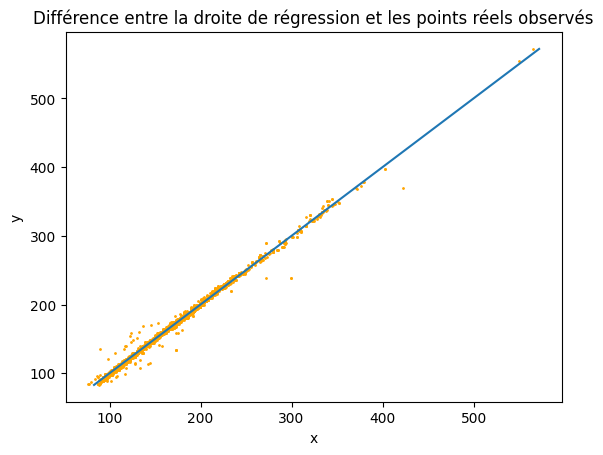

In [ ]:
plt.scatter(y_pred_test, y_test, color='orange', s=1)
plt.plot((y_test.min(), y_test.max()),(y_test.min(), y_test.max()));
plt.title("Différence entre la droite de régression et les points réels observés")
plt.xlabel("x")
plt.ylabel("y");
#Les points cibles sont très proches de la droite de régression élaborée par le modèle.

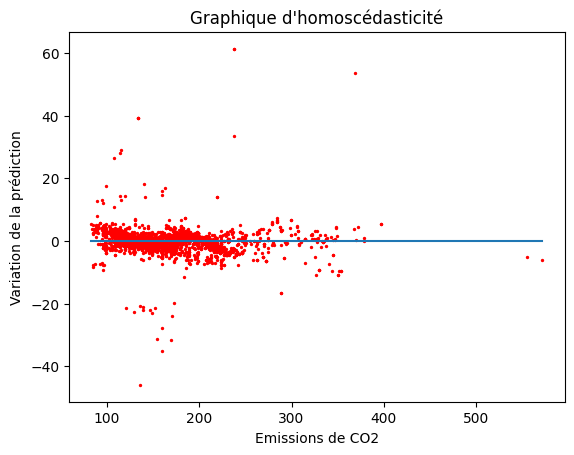

In [ ]:
#Vérification de l'hypothèse d'homoscédasticité

residus = y_pred_test - y_test

plt.scatter(y_test, residus, color='red', s=2)
plt.plot((y_test.min(), y_test.max()), (0,0))
plt.title("Graphique d'homoscédasticité")
plt.xlabel("Emissions de CO2")
plt.ylabel("Variation de la prédiction");
#La variance maximale n'excède pas 70g, càd que l'écart maximal constaté entre la valeur réelle et la valeur prédite est < 70g
#Tous les points sont centrées autour de 0, ce qui signifie que la régression linéaire est appropriée pour ce type de problème.

Entrainement sur données standardisées

In [ ]:
#Linear Regression avec les données standardisées
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

scores["Entrainement"]["lr"] = lr.score(X_train_scaled, y_train)
scores["Test"]["lr"]  = lr.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", lr.score(X_train_scaled, y_train))
print("Score sur set de test :", lr.score(X_test_scaled, y_test))

y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))
print("\nLe résultat de la régression est identique avec ou sans données standardisées.")

Score sur set d'entrainement : 0.992898181793661
Score sur set de test : 0.9935471082404506

RMSE sur set d'entrainement : 4.295035292683255
RMSE sur set de test : 4.080478982086387

Le résultat de la régression est identique avec ou sans données standardisées.


**ELASTIC NET** (méthode utilisée lorsque la colinéarité entre variable est forte, ce qui est notre cas ici)

In [ ]:
El_net = ElasticNetCV(cv=3, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1))

El_net.fit(X_train_scaled, y_train)

scores["Entrainement"]["El_net"] = El_net.score(X_train_scaled, y_train)
scores["Test"]["El_net"]  = El_net.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", El_net.score(X_train_scaled, y_train))
print("Score sur set de test :", El_net.score(X_test_scaled, y_test))

y_pred_train = El_net.predict(X_train_scaled)
y_pred_test = El_net.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69237.36323999011, tolerance: 2106.5601963288955
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51982.75135597885, tolerance: 2047.7103010685105
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68801.80477135496, tolerance: 2044.4762413073552
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergence

Score sur set d'entrainement : 0.9927703350674069
Score sur set de test : 0.993527677672613

RMSE sur set d'entrainement : 4.333522404958796
RMSE sur set de test : 4.086617813401346


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.017e+05, tolerance: 3.099e+03
  model = cd_fast.enet_coordinate_descent(


In [ ]:
rfe = RFE(estimator = lr, step=1, n_features_to_select = 30)
rfe.fit(X_train_scaled, y_train)

scores["Entrainement"]["rfe"] = rfe.score(X_train_scaled, y_train)
scores["Test"]["rfe"]  = rfe.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", rfe.score(X_train_scaled, y_train))
print("Score sur set de test :", rfe.score(X_test_scaled, y_test))

y_pred_train = rfe.predict(X_train_scaled)
y_pred_test = rfe.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.992898181793661
Score sur set de test : 0.9935471082404506

RMSE sur set d'entrainement : 4.295035292683255
RMSE sur set de test : 4.080478982086387


**ARBRE DE DECISION**

Données non standardisées

In [ ]:
dt1 = DecisionTreeRegressor()
dt1.fit(X_train, y_train)

scores["Entrainement"]["dt1"] = dt1.score(X_train, y_train)
scores["Test"]["dt1"]  = dt1.score(X_test, y_test)

print("Score sur set d'entrainement :", dt1.score(X_train, y_train))
print("Score sur set de test :", dt1.score(X_test, y_test))

y_pred_train = dt1.predict(X_train)
y_pred_test = dt1.predict(X_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.999996750519691
Score sur set de test : 0.9981590721668216

RMSE sur set d'entrainement : 0.0918732153923409
RMSE sur set de test : 2.1794772345193025


Données standardisées

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train_scaled, y_train)

scores["Entrainement"]["dt"] = dt.score(X_train_scaled, y_train)
scores["Test"]["dt"]  = dt.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", dt.score(X_train_scaled, y_train))
print("Score sur set de test :", dt.score(X_test_scaled, y_test))

y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))
print("\nLes résultats sont quasi-identiques quoique légèrement meilleurs sur données standardisées.")

Score sur set d'entrainement : 0.9999968473127214
Score sur set de test : 0.9976764048058682

RMSE sur set d'entrainement : 0.09049454661101425
RMSE sur set de test : 2.448579390924666

Les résultats sont quasi-identiques quoique légèrement meilleurs sur données standardisées.


**SVM**

Données non standardisées

In [ ]:
svm_model1 = svm.SVR()
svm_model1.fit(X_train, y_train)

scores["Entrainement"]["svm_model1"] = svm_model1.score(X_train, y_train)
scores["Test"]["svm_model1"]  = svm_model1.score(X_test, y_test)

print("Score sur set d'entrainement :", svm_model1.score(X_train, y_train))
print("Score sur set de test :", svm_model1.score(X_test, y_test))

y_pred_train = svm_model1.predict(X_train)
y_pred_test = svm_model1.predict(X_test)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))
print("Le score obtenu est très mauvais. Un grand nombre de paramètre doit être optimisé lorsqu'on utilise un SVM.")

Score sur set d'entrainement : 0.5305968277596149
Score sur set de test : 0.5481046662452504

RMSE sur set d'entrainement : 34.91845112247286
RMSE sur set de test : 34.14702586149925
Le score obtenu est très mauvais. Un grand nombre de paramètre doit être optimisé lorsqu'on utilise un SVM.


Données standardisées

In [ ]:
svm_model = svm.SVR()
svm_model.fit(X_train_scaled, y_train)

scores["Entrainement"]["svm_model"] = svm_model.score(X_train_scaled, y_train)
scores["Test"]["svm_model"]  = svm_model.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", svm_model.score(X_train_scaled, y_train))
print("Score sur set de test :", svm_model.score(X_test_scaled, y_test))

y_pred_train = svm_model.predict(X_train_scaled)
y_pred_test = svm_model.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))


Score sur set d'entrainement : 0.9347137183627409
Score sur set de test : 0.9243115648760803

RMSE sur set d'entrainement : 13.022456890818315
RMSE sur set de test : 13.97490029753995


In [ ]:
#D'une manière générale, les résultats obtenus sont meilleurs lorsque l'on se base sur des données standardisées
pd.DataFrame(scores)

,Entrainement,Test
lr1,0.992898,0.993547
lr,0.992898,0.993547
dt1,0.999997,0.998159
dt,0.999997,0.997676
svm_model1,0.530597,0.548105
svm_model,0.934714,0.924312


On entrainera les prochains modèles avec les données standardisées

In [ ]:
#Suppression des modèles avec données non standards du dictionnaire.
modele_non_standards = ["lr1", "dt1", "svm_model1"]
dicos = ["Entrainement", "Test"]

for cle, valeur in scores.items():
  for sous_cle, sous_valeur in list(valeur.items()):
    if sous_cle in modele_non_standards:
      del valeur[sous_cle]

## Modélisation avancée

In [ ]:
#On peut entraîner des modèles plus complexes pour voir quels seront les résultats obtenus :

#Foret aléatoires (cas particulier de Bootstrapping/Bagging)
#Boosting avec la régression linéaire

#VotingRegressor (reg linéaire, forêt aléatoire, svm.SVR selon meilleurs paramètres de chaque modèle)
#StackingRegressor (indiquer le nb de fold vc et bien prendre les meilleurs param pour les classifieurs sélectionnés)


**FORET ALEATOIRE** *base : arbre de décision*

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, random_state=123)
rf.fit(X_train_scaled, y_train)

scores["Entrainement"]["rf"] = rf.score(X_train_scaled, y_train)
scores["Test"]["rf"]  = rf.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", rf.score(X_train_scaled, y_train))
print("Score sur set de test :", rf.score(X_test_scaled, y_test))

y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.9997919272790874
Score sur set de test : 0.9986390488491178

RMSE sur set d'entrainement : 0.7351729759133427
RMSE sur set de test : 1.873938024431233


In [ ]:
#Ensuite, le résultat sur set de test est meilleur avec le modèle Random Forest que sur l'arbre de décision "simple" :
#- Score = 0.9986 pour Random Forest
#- Score = 0.9963 pour l'arbre de décision

#C'est léger mais on observe que le RandomForest réduit le sur-apprentissage de l'arbre de décision "simple" :
#- Différence de score entre train et test pour le Random Forest :  0.001
#- Différence de score entre train et test pour l'arbre de décision :  0.0036

#Le modèle Random Forest est donc meilleur à tout point de vue par rapport à l'arbre de décision
#L'échelle de comparaison est infime parce que les 2 modèles obtiennent la quasi-justesse de prédictions.


**BOOSTING**
*base : Régression Linéaire*

In [ ]:
ada_lr = AdaBoostRegressor(base_estimator=lr, n_estimators=400)
ada_lr.fit(X_train_scaled, y_train)

scores["Entrainement"]["ada_lr"] = ada_lr.score(X_train_scaled, y_train)
scores["Test"]["ada_lr"]  = ada_lr.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", ada_lr.score(X_train_scaled, y_train))
print("Score sur set de test :", ada_lr.score(X_test_scaled, y_test))

y_pred_train = ada_lr.predict(X_train_scaled)
y_pred_test = ada_lr.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Score sur set d'entrainement : 0.9880073550830296
Score sur set de test : 0.9880010532134347

RMSE sur set d'entrainement : 5.581352460008856
RMSE sur set de test : 5.564235704571579


*base : Arbre de Décision*

In [ ]:
ada_dt = AdaBoostRegressor(n_estimators=400)
ada_dt.fit(X_train_scaled, y_train)

scores["Entrainement"]["ada_dt"] = ada_dt.score(X_train_scaled, y_train)
scores["Test"]["ada_dt"]  = ada_dt.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", ada_dt.score(X_train_scaled, y_train))
print("Score sur set de test :", ada_dt.score(X_test_scaled, y_test))

y_pred_train = ada_dt.predict(X_train_scaled)
y_pred_test = ada_dt.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.9501468155225092
Score sur set de test : 0.9485933136420932

RMSE sur set d'entrainement : 11.37963713524052
RMSE sur set de test : 11.517116509171935


In [ ]:
#Comparativement aux autres modèles, le Boosting n'est pas une alternative convaincante.
#Le Boosting n'est pas une solution adaptée à notre problème (les scores sont de 0.98 pour la régression linéaire et 0.95 pour l'arbre de décision).

**VOTING REGRESSOR**

In [ ]:
#Avant d'entrainer le Voting Regressor, nous allons chercher à identifier les meilleurs paramètres pour chaque modèle.

GridSearchCV : Forêt aléatoires

In [ ]:
params = {'n_estimators': [20, 100, 200],
          'max_depth': [3, 6]}
grid = GridSearchCV(estimator=rf, param_grid=params, cv=3)
grid = grid.fit(X_train_scaled, y_train)
print(grid.best_params_)

{'max_depth': 6, 'n_estimators': 200}


In [ ]:
pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'max_depth': 3, 'n_estimators': 20}",0.942872,4
1,"{'max_depth': 3, 'n_estimators': 100}",0.942170,6
2,"{'max_depth': 3, 'n_estimators': 200}",0.942581,5
3,"{'max_depth': 6, 'n_estimators': 20}",0.989374,3
4,"{'max_depth': 6, 'n_estimators': 100}",0.989405,2
5,"{'max_depth': 6, 'n_estimators': 200}",0.989552,1


In [ ]:
#Les résultats obtenues par grille de recherche sont moins bon que le modèle de base.
#Cela est dû à la limitation de profondeurs des arbres modélisés (on voit tout de suite les différences d performance selon la variation de profondeur)
#Une forêt aléatoire prévient les problèmes d'overfitting, il n'est donc pas nécessaire de limiter la profondeur des arbres.
#Il pourrait être intéressant de comparer une forêt avec 100 itérations (par défaut) VS 200 itérations. Ce duel permettrait de conclure

In [ ]:
rf_200 = RandomForestRegressor(n_jobs=-1, random_state=123, n_estimators=200)
rf_200.fit(X_train_scaled, y_train)

scores["Entrainement"]["rf_200"] = rf_200.score(X_train_scaled, y_train)
scores["Test"]["rf_200"]  = rf_200.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", rf_200.score(X_train_scaled, y_train))
print("Score sur set de test :", rf_200.score(X_test_scaled, y_test))

y_pred_train = rf_200.predict(X_train_scaled)
y_pred_test = rf_200.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.9998170218355751
Score sur set de test : 0.9987329036626323

RMSE sur set d'entrainement : 0.6894163751368736
RMSE sur set de test : 1.8081679740375538


GridSearchCV SVM

In [ ]:
params = {'C': [0.1,1, 10],
          'gamma': [0.001, 0.01, 0.5],
          'kernel': ['linear', 'rbf']}
grid = GridSearchCV(estimator=svm_model, param_grid=params, n_jobs=-1)
grid = grid.fit(X_train_scaled, y_train)
print(grid.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}",0.990649,2
1,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.236469,18
2,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}",0.990649,2
3,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.766665,15
4,"{'C': 0.1, 'gamma': 0.5, 'kernel': 'linear'}",0.990649,2
5,"{'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}",0.350852,17
6,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",0.990478,5
7,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.925487,13
8,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}",0.990478,5
9,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.951551,12


In [ ]:
#Le kernel linear offre plus de stabilité car ses performances sont similaires dans toutes ces variantes
#Le kernel rbf, bien que proposant la combinaison des meilleurs paramètres est plus aléatoire.
#Notre choix se porte donc sur le 2ème meilleur paramètres.

In [ ]:
best_svm = svm.SVR(C=0.1, kernel='linear')
best_svm.fit(X_train_scaled, y_train)

scores["Entrainement"]["best_svm"] = best_svm.score(X_train_scaled, y_train)
scores["Test"]["best_svm"]  = best_svm.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", best_svm.score(X_train_scaled, y_train))
print("Score sur set de test :", best_svm.score(X_test_scaled, y_test))

y_pred_train = best_svm.predict(X_train_scaled)
y_pred_test = best_svm.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.9906622562986064
Score sur set de test : 0.9922838702183777

RMSE sur set d'entrainement : 4.92496259116112
RMSE sur set de test : 4.462042647395492


In [ ]:
VotingReg1 = VotingRegressor(estimators=[('Régression Linéaire', lr), ('Random Forest', rf), ('SVM', best_svm)])
VotingReg1.fit(X_train_scaled, y_train)

scores["Entrainement"]["VotingReg1"] = VotingReg1.score(X_train_scaled, y_train)
scores["Test"]["VotingReg1"]  = VotingReg1.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", VotingReg1.score(X_train_scaled, y_train))
print("Score sur set de test :", VotingReg1.score(X_test_scaled, y_test))

y_pred_train = VotingReg1.predict(X_train_scaled)
y_pred_test = VotingReg1.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.9964243017139041
Score sur set de test : 0.9963819979732766

RMSE sur set d'entrainement : 3.047631084268145
RMSE sur set de test : 3.055401995625495


In [ ]:
VotingReg = VotingRegressor(estimators=[('Régression Linéaire', lr), ('Random Forest', rf), ('SVM', best_svm), ('Arbre', dt)])
VotingReg.fit(X_train_scaled, y_train)

scores["Entrainement"]["VotingReg"] = VotingReg.score(X_train_scaled, y_train)
scores["Test"]["VotingReg"]  = VotingReg.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", VotingReg.score(X_train_scaled, y_train))
print("Score sur set de test :", VotingReg.score(X_test_scaled, y_test))

y_pred_train = VotingReg.predict(X_train_scaled)
y_pred_test = VotingReg.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.9979872900269022
Score sur set de test : 0.9973151917399535

RMSE sur set d'entrainement : 2.286507133374274
RMSE sur set de test : 2.6320285310324616


In [ ]:
#On constate qu'en ajoutant l'arbre de décision, on augmente la performance sur set de test mais on augmente de façon plus que proportionnelle l'écart de perf entre set de train et set de test (overfitting)
#C'est logique car l'arbre fait preuve de plus d'overfitting que les autres modèles.

In [ ]:
StackingReg1 = StackingRegressor(estimators=[('Régression Linéaire', lr), ('Random Forest', rf), ('SVM', best_svm)], final_estimator=lr)

StackingReg1.fit(X_train_scaled, y_train)

scores["Entrainement"]["StackingReg1"] = StackingReg1.score(X_train_scaled, y_train)
scores["Test"]["StackingReg1"]  = StackingReg1.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", StackingReg1.score(X_train_scaled, y_train))
print("Score sur set de test :", StackingReg1.score(X_test_scaled, y_test))

y_pred_train = StackingReg1.predict(X_train_scaled)
y_pred_test = StackingReg1.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.9996355054727243
Score sur set de test : 0.9986410700485078

RMSE sur set d'entrainement : 0.9730327712242443
RMSE sur set de test : 1.872545979716024


In [ ]:
StackingReg = StackingRegressor(estimators=[('Régression Linéaire', lr), ('Random Forest', rf), ('SVM', best_svm), ('Arbre', dt)], final_estimator=lr)

StackingReg.fit(X_train_scaled, y_train)

scores["Entrainement"]["StackingReg"] = StackingReg.score(X_train_scaled, y_train)
scores["Test"]["StackingReg"]  = StackingReg.score(X_test_scaled, y_test)

print("Score sur set d'entrainement :", StackingReg.score(X_train_scaled, y_train))
print("Score sur set de test :", StackingReg.score(X_test_scaled, y_test))

y_pred_train = StackingReg.predict(X_train_scaled)
y_pred_test = StackingReg.predict(X_test_scaled)

MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

#RMSE
print("\nRMSE sur set d'entrainement :", np.sqrt(MSE_train))
print("RMSE sur set de test :", np.sqrt(MSE_test))

Score sur set d'entrainement : 0.9996543913766045
Score sur set de test : 0.9986203350108273

RMSE sur set d'entrainement : 0.9474891521798585
RMSE sur set de test : 1.8867778834512725


In [ ]:
#L'intégration de l'arbre dans le Stacking montre clairement son effet de sur-apprentissage.
#En plus, il dégrade la performance sur le set de test

In [ ]:
tableau_recap = pd.DataFrame(scores)
tableau_recap['Delta Entrainement-Test'] = tableau_recap['Entrainement'] - tableau_recap['Test']
tableau_recap.sort_values(by="Test", ascending=False)

,Entrainement,Test,Delta Entrainement-Test
rf_200,0.999817,0.998733,0.001084
StackingReg1,0.999636,0.998641,0.000994
rf,0.999792,0.998639,0.001153
StackingReg,0.999654,0.998620,0.001034
dt,0.999997,0.997676,0.002320
VotingReg,0.997987,0.997315,0.000672
VotingReg1,0.996424,0.996382,0.000042
lr,0.992898,0.993547,-0.000649
best_svm,0.990662,0.992284,-0.001622
ada_lr,0.988007,0.988001,0.000006


# INTERPRÉTABILITÉ

In [ ]:
#Coef_ positifs pour la régression linéaire
feats_lr={}

for feature, importance, in zip(X_train, lr.coef_):
  feats_lr[feature] = importance

importances = pd.DataFrame.from_dict(feats_lr, orient='index').rename(columns={0: 'Coefficient'})

importances.sort_values(by='Coefficient', ascending=False).head(7)

,Coefficient
Consommation mixte (l/100km),38.914359
Consommation extra-urbaine (l/100km),7.481250
Consommation urbaine (l/100km),5.394725
Carburant_GO,4.513410
masse vide euro min (kg),1.790132
Carrosserie_MINIBUS,1.608209
Puissance maximale (kW),1.017331


In [ ]:
#Coef_ négatifs pour la régression linéaire
importances.sort_values(by='Coefficient', ascending=True).head()

,Coefficient
Carburant_FE,-5.871244
Carburant_ES+,-3.410181
Carburant_ES,-2.712111
Carburant_GN,-2.243793
Puissance administrative,-0.958502


In [ ]:
#En valeur absolue
importances['Coefficient'] = importances['Coefficient'].apply(lambda x: x*-1 if x<0 else x)

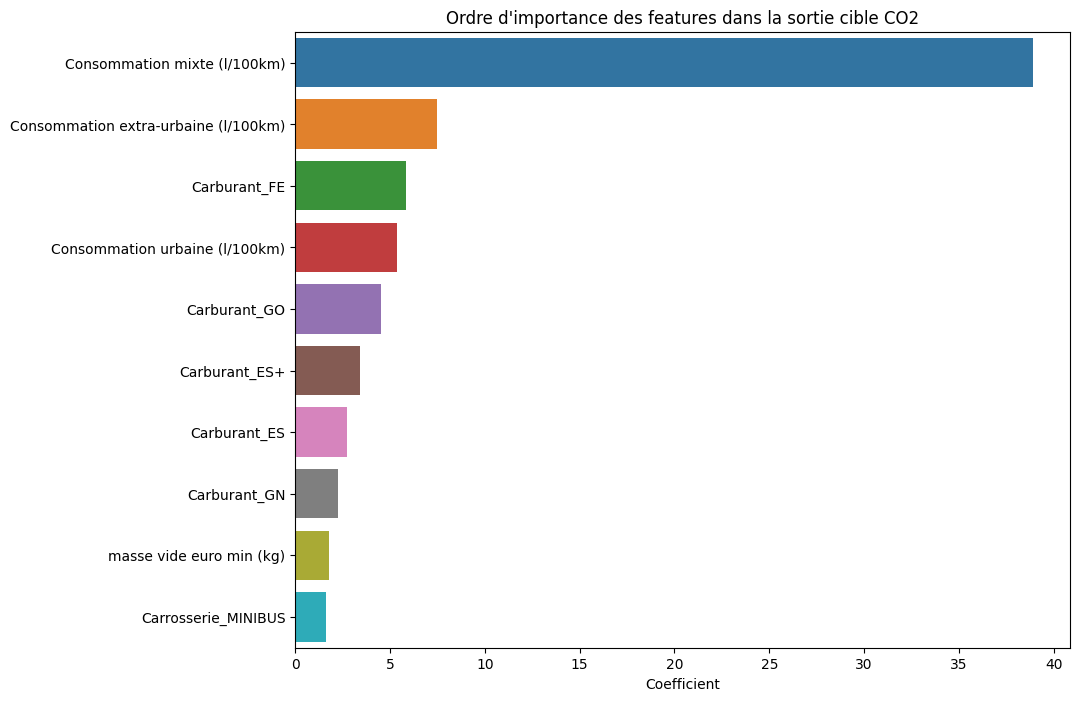

In [ ]:
#Graphique en valeur absolue
val_abs = importances.sort_values(by='Coefficient', ascending=False).head(10)
plt.figure(figsize=(10,8))
sns.barplot(x='Coefficient', y=val_abs.index, data=val_abs)
plt.title("Ordre d'importance des features dans la sortie cible CO2");

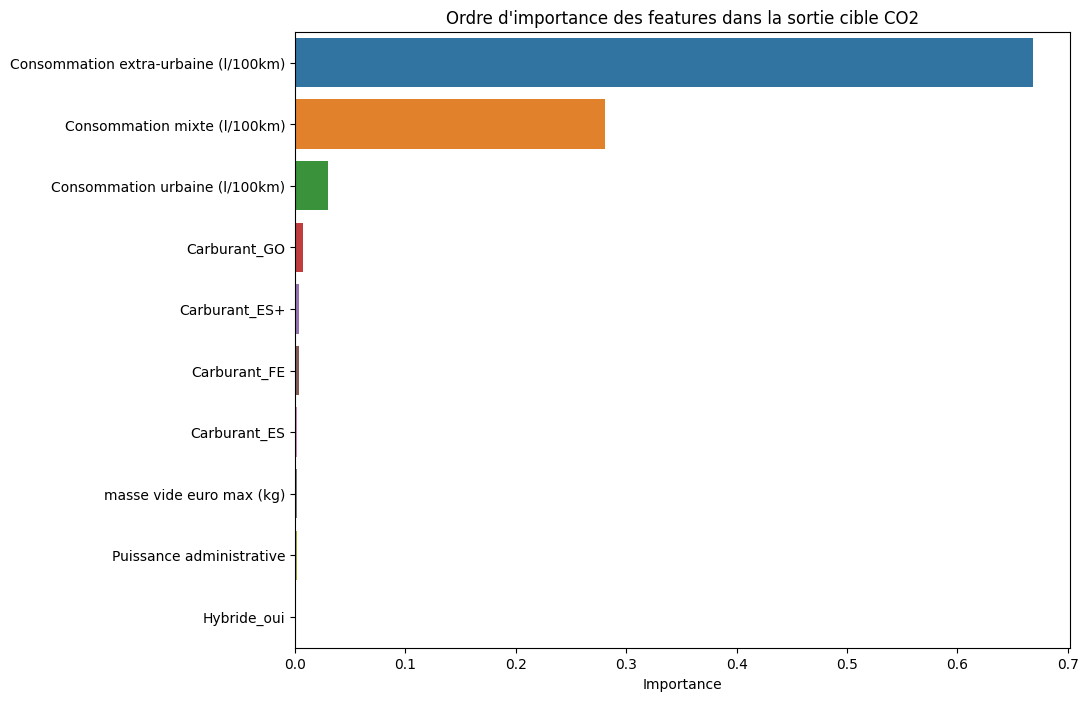

In [ ]:
#feature_importances pour l'arbre de décision
feats_dt={}

for feature, importance, in zip(X_train, dt.feature_importances_):
  feats_dt[feature] = importance

importance = pd.DataFrame.from_dict(feats_dt, orient='index').rename(columns={0: 'Importance'})
importance = importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y=importance.index, data=importance)
plt.title("Ordre d'importance des features dans la sortie cible CO2");